## EY Datawave Challenge Code

**Simple rule**: 
- all "df_xx" types are pd.DataFrame
- "xx_data" are usually NumPy arrays

# What is in this Version:

Before, we have been predicting by considering all the trajectories separately. Yet, this approach may be misleading in that our goal is to predict **each person's position between 15:00 ~ 16:00 PM, not other time period.** So, it may be better to group trajectories of the same person into one row.

What I used for feature here:

1. Total time elapsed
2. distance from park center (last point)
3. within the park center (last trajectories' entry)
4. within the park center (overall trajectories' exit)
5. Average Velocity
6. Average Bearing (maybe deviation angle from the straight line from starting point to park center?)
7. velocity of last trajectory


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing, model_selection
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import math
import tensorflow.keras.preprocessing.sequence as sequence

# pd.set_option('display.max_columns', None)

# Cool point got from here

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Create a Callback

In [3]:
class MyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') >= 0.98:
            print("Reached 98% acc so cancelling training!")
            self.model.stop_training = True

reach_90acc = MyCallback()

# Metric for F1

https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

In [4]:
class F1(keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.validation_data = val_data
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print ("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        if _val_f1 >= 0.892:
            print ("F1 reached 89.2! Stopping")
            self.model.stop_training = True
        return

# Bearing Function

In [5]:
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

# Read the Data

df is training data + label

In [6]:
#read training data
raw_train = pd.read_csv("/Users/Godwithus/Desktop/EY/data_train.csv", low_memory=False) #nrows = integer
raw_train = raw_train.loc[:,'hash':'y_exit']
raw_train.fillna('', inplace=True)

#read test data
raw_test = pd.read_csv("/Users/Godwithus/Desktop/EY/data_test.csv", low_memory=False)
raw_test = raw_test.loc[:,'hash':'y_exit']
raw_test.fillna('', inplace=True)

# Before Grouping, perform some common tasks

In [7]:
#time to seconds
df_train = raw_train
df_train['time_entry_seconds'] = pd.to_timedelta(df_train['time_entry']).dt.total_seconds()
df_train['time_exit_seconds']=pd.to_timedelta(df_train['time_exit']).dt.total_seconds()

df_test = raw_test
df_test['time_entry_seconds'] = pd.to_timedelta(df_test['time_entry']).dt.total_seconds()
df_test['time_exit_seconds']=pd.to_timedelta(df_test['time_exit']).dt.total_seconds()

## Some look at the data

In [8]:
#debugging

# print (df_train.info())
# print (df_test.info())

# df_test.describe()

In [9]:
def feature_extract(one_traj, single = False):

    # 1. total time elapsed (seconds)

    one_traj['total_time'] = one_traj['time_exit_seconds'] - one_traj['time_entry_seconds']

    # 2. prepare whether entry point is in cityhall

    x_in_city = (one_traj['x_entry'] >=3750901.5068) & (one_traj['x_entry']<=3770901.5068)
    y_in_city = (one_traj['y_entry'] >= -19268905.6133) & (one_traj['y_entry'] <= -19208905.6133)

    one_traj['entry_inside'] = 1*(x_in_city & y_in_city)


    # 3. the distance from the entry point of last trajectory from the city hall's mid point

    one_traj['distance_from_center'] = ((3760901.5068 - one_traj['x_entry']).pow(2) + \
                            (-19238905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)


    # 4. distance from city hall boundaries

    one_traj.loc[(one_traj['x_entry'] >=3750901.5068) & (one_traj['x_entry']<=3770901.5068) & (one_traj['y_entry'] >= -19268905.6133) & (one_traj['y_entry'] <= -19208905.6133), 'distance_2'] = 0
    one_traj.loc[(one_traj['x_entry'] <3750901.5068) & (one_traj['y_entry'] >= -19268905.6133) & (one_traj['y_entry'] <= -19208905.6133), 'distance_2'] = 3750901.5068 - one_traj['x_entry']
    one_traj.loc[(one_traj['x_entry']>3770901.5068) & (one_traj['y_entry'] >= -19268905.6133) & (one_traj['y_entry'] <= -19208905.6133), 'distance_2'] = one_traj['x_entry'] - 3770901.5068
    one_traj.loc[(one_traj['x_entry'] >=3750901.5068) & (one_traj['x_entry']<=3770901.5068) & (one_traj['y_entry'] < -19268905.6133), 'distance_2'] = -19268905.6133 - one_traj['y_entry']
    one_traj.loc[(one_traj['x_entry'] >=3750901.5068) & (one_traj['x_entry']<=3770901.5068) & (one_traj['y_entry'] > -19208905.6133), 'distance_2'] = one_traj['y_entry'] + 19208905.6133
    one_traj.loc[(one_traj['x_entry']>3770901.5068) & (one_traj['y_entry'] > -19208905.6133), 'distance_2'] = ((3770901.5068 - one_traj['x_entry']).pow(2) + (-19208905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)
    one_traj.loc[(one_traj['x_entry'] <3750901.5068) & (one_traj['y_entry'] > -19208905.6133), 'distance_2'] = ((3750901.5068 - one_traj['x_entry']).pow(2) + (-19208905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)
    one_traj.loc[(one_traj['x_entry']>3770901.5068) & (one_traj['y_entry'] < -19268905.6133), 'distance_2'] = ((3770901.5068 - one_traj['x_entry']).pow(2) + (-19268905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)
    one_traj.loc[(one_traj['x_entry'] <3750901.5068) & (one_traj['y_entry'] < -19268905.6133), 'distance_2'] = ((3750901.5068 - one_traj['x_entry']).pow(2) + (-19268905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)
    
    #5. bearing between city center and 
    
    b = []
    for i in range(len(one_traj['x_entry'].values)):
        b.append(calculate_initial_compass_bearing((one_traj['x_entry'].values[i], one_traj['y_entry'].values[i]) , \
                                     (3760901.5068,  -19238905.6133)))

    bearing = np.array(b)
    df_bearing = pd.DataFrame(bearing, columns = ['bearing_center'])
    df_bearing.index = one_traj.index
    one_traj = one_traj.merge(df_bearing, left_index=True, right_index=True)
    
    
    #6. bearing
    if not single:
        a = []
        for i in range(len(one_traj['x_entry'].values)):
            a.append(calculate_initial_compass_bearing((one_traj['x_entry'].values[i], one_traj['y_entry'].values[i]) , \
                                         (one_traj['x_exit'].values[i],  one_traj['y_exit'].values[i])))

        bearing = np.array(a)
        df_bearing = pd.DataFrame(bearing, columns = ['bearing'])
        df_bearing.index = one_traj.index
        one_traj = one_traj.merge(df_bearing, left_index=True, right_index=True)
        
    #7. Bearing difference
    if not single:
        one_traj['bearing_diff'] = one_traj['bearing_center']-one_traj['bearing']
        one_traj.loc[one_traj.bearing_diff > 180, 'bearing_diff'] = -360 + one_traj.bearing_diff
        one_traj.loc[one_traj.bearing_diff < -180, 'bearing_diff'] = 360 + one_traj.bearing_diff 
        
    #6. vmean    velocity of human: 4.6 ft/s
    if not single:
        one_traj.loc[one_traj.total_time==0,'vmean'] = 0
        one_traj.loc[one_traj.total_time > 0,'vmean'] = ((((one_traj['x_exit'] - one_traj['x_entry']).pow(2) + (one_traj['y_exit'] - one_traj['y_entry']).pow(2)).pow(1/2)) / one_traj['total_time'])
        one_traj.vmean = one_traj['vmean'].astype('float64')
        
    #Distance travelled for monitoring purpose
    if not single:
        one_traj['travelled-dist']=((one_traj['x_exit'] - one_traj['x_entry']).pow(2) + (one_traj['y_exit'] - one_traj['y_entry']).pow(2)).pow(1/2)


    
    return one_traj

In [10]:
def make_label(df_data, last_traj):
    #prepare training label

    target_x = (last_traj['x_exit']>=3750901.5068) & (last_traj['x_exit']<=3770901.5068)
    target_y = (last_traj['y_exit']>=-19268905.6133) & (last_traj['y_exit']<=-19208905.6133)

    train_label = 1*(target_x & target_y)
    df_data['train_label'] = train_label.values


    train_label = train_label.values
    
    return df_data, train_label

In [11]:
a = feature_extract(df_train, single=False)

last = a.groupby('hash', as_index=False).last()

# Prepare Bearing Dataset

In [12]:
#prepare bearing data and target

bearing_train = a
bearing_target = last

single_bearing = bearing_train.groupby('hash', as_index = False).count()
single_bearing = single_bearing[single_bearing['bearing']==1]
single_bearing = bearing_target.loc[single_bearing.index]

#single+everything row except last traj
bearing_train = bearing_train.merge(bearing_target, how='left', indicator=True)

bearing_train = bearing_train[(bearing_train['_merge']=='left_only')]

zero = single_bearing
zero['entry_inside'] = 0
zero['bearing']=0
zero['bearing_center'] = 0
zero['bearing_diff'] = 0

bearing_train = bearing_train.append(zero, sort=True)

# bearing_train.sort_index(inplace=True)

bearing_train = bearing_train.loc[:,['hash','entry_inside','bearing','bearing_center', 'bearing_diff']]
bearing_target = bearing_target['bearing']

In [13]:
#normalize
bearing_train_data = bearing_train.values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(bearing_train_data[:,[2,3,4]])

bearing_train_data = np.concatenate((bearing_train_data[:,[0,1]],normalized_col), axis = 1)

df_bearing_train_data = pd.DataFrame(bearing_train_data)

df_bearing_train_data.columns = ['hash','entry_inside','bearing','bearing_center', 'bearing_diff']

#Flatten
cc = df_bearing_train_data.groupby('hash').cumcount() + 1
df_bearing_train_data = df_bearing_train_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_bearing_train_data.columns = ['_'.join(map(str,i)) for i in df_bearing_train_data.columns]
df_bearing_train_data.reset_index()

df_bearing_train_data.fillna(0, inplace = True)

df_bearing_train_data['target'] = bearing_target

bearing_train_data=df_bearing_train_data[(df_bearing_train_data['target']!=0)]
bearing_train_data.drop('target', axis=1, inplace=True)
bearing_target = bearing_target.values

#Add the last trajectory's two properties
bearing_train_data['entry_inside'] = last['entry_inside'].values
bearing_train_data['zero_pedding_1'] = 0
bearing_train_data['bearing_center'] = last['bearing_center'].values
bearing_train_data['zero_pedding_2'] = 0

print (bearing_train_data.describe())
print (last.describe())

bearing_train_data = bearing_train_data.values

#reshape
bearing_train_data = bearing_train_data.reshape(134063, 20, 4)

/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


       entry_inside_19  bearing_diff_19  bearing_center_19     bearing_19  \
count    134063.000000    134063.000000      134063.000000  134063.000000   
mean          0.000410         0.000617           0.000586       0.000275   
std           0.020251         0.020594           0.019565       0.013597   
min           0.000000         0.000000           0.000000       0.000000   
25%           0.000000         0.000000           0.000000       0.000000   
50%           0.000000         0.000000           0.000000       0.000000   
75%           0.000000         0.000000           0.000000       0.000000   
max           1.000000         0.998306           0.960620       0.992741   

       entry_inside_18  bearing_diff_18  bearing_center_18     bearing_18  \
count    134063.000000    134063.000000      134063.000000  134063.000000   
mean          0.001261         0.001858           0.001865       0.001047   
std           0.035483         0.035192           0.034819       0.027000  

# Prepare Vmean Data set

In [14]:
#prepare vmean data and target

vmean_train = a
vmean_target = last

single_vmean = vmean_train.groupby('hash', as_index = False).count()
single_vmean = single_vmean[single_vmean['vmean']==1]
single_vmean = vmean_target.loc[single_vmean.index]

#single+everything row except last traj
vmean_train = vmean_train.merge(vmean_target, how='left', indicator=True)

vmean_train = vmean_train[(vmean_train['_merge']=='left_only')]

zero = single_vmean
zero['entry_inside'] = 0
zero['total_time']=0
zero['distance_from_center'] = 0
zero['distance_2'] = 0
zero['bearing_center'] = 0
zero['vmean']=0
zero['travelled-dist'] = 0
vmean_train = vmean_train.append(zero, sort=True)

# bearing_train.sort_index(inplace=True)

vmean_train = vmean_train.loc[:,['hash','entry_inside','total_time',
                                     'distance_from_center', 'distance_2', 
                                     'bearing_center', 'vmean', 'travelled-dist']]
vmean_target = vmean_target['vmean']

In [15]:
#normalize
vmean_train_data = vmean_train.values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(vmean_train_data[:,[2,3,4,5,6,7]])

vmean_train_data = np.concatenate((vmean_train_data[:,[0,1]],normalized_col), axis = 1)

df_vmean_train_data = pd.DataFrame(vmean_train_data)

df_vmean_train_data.columns = ['hash','entry_inside','total_time',
                                     'distance_from_center', 'distance_2', 
                                     'bearing_center', 'vmean', 'travelled-dist']

#Flatten
cc = df_vmean_train_data.groupby('hash').cumcount() + 1
df_vmean_train_data = df_vmean_train_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_vmean_train_data.columns = ['_'.join(map(str,i)) for i in df_vmean_train_data.columns]
df_vmean_train_data.reset_index()

df_vmean_train_data.fillna(0, inplace = True)

df_vmean_train_data['target'] = vmean_target

vmean_train_data=df_vmean_train_data[(df_vmean_train_data['target']!=0)]
vmean_train_data.drop('target', axis=1, inplace=True)
vmean_target = vmean_target.values

#Add the last trajectory's properties
vmean_train_data['zero_pedding_vmean'] = 0
vmean_train_data['zero_pedding_travelled_dist'] = 0
vmean_train_data['total_time'] = last['total_time'].values
vmean_train_data['entry_inside'] = last['entry_inside'].values
vmean_train_data['distance_from_center'] = last['distance_from_center'].values
vmean_train_data['distance_2'] = last['distance_2'].values
vmean_train_data['bearing_center'] = last['bearing_center'].values

print(vmean_train_data.head())
vmean_train_data = vmean_train_data.values

#reshape
vmean_train_data = vmean_train_data.reshape(134063, 20, 7)

                                     vmean_19  travelled-dist_19  \
hash                                                               
0000a8602cf2def930488dee7cdad104_1        0.0                0.0   
0000cf177130469eeac79f67b6bcf3df_9        0.0                0.0   
0001f97b99a80f18f62e2d44e54ef33d_3        0.0                0.0   
0002124248b0ca510dea42824723ccac_31       0.0                0.0   
000219c2a6380c307e8bffd85b5e404b_23       0.0                0.0   

                                     total_time_19  entry_inside_19  \
hash                                                                  
0000a8602cf2def930488dee7cdad104_1             0.0                0   
0000cf177130469eeac79f67b6bcf3df_9             0.0                0   
0001f97b99a80f18f62e2d44e54ef33d_3             0.0                0   
0002124248b0ca510dea42824723ccac_31            0.0                0   
000219c2a6380c307e8bffd85b5e404b_23            0.0                0   

                         

# Prepare all train data set

In [16]:
#normalize
a = a.loc[:,['hash','entry_inside','total_time','distance_from_center',
             'distance_2','bearing','bearing_center','bearing_diff','vmean']]
train_data = a.values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(train_data[:,[2,3,4,5,6,7,8]])

train_data = np.concatenate((train_data[:,[0,1]],normalized_col), axis = 1)

df_train_data = pd.DataFrame(train_data)

df_train_data.columns = ['hash','entry_inside','total_time','distance_from_center',
                         'distance_2','bearing','bearing_center','bearing_diff','vmean']

#Flatten
cc = df_train_data.groupby('hash').cumcount() + 1
df_train_data = df_train_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_train_data.columns = ['_'.join(map(str,i)) for i in df_train_data.columns]
df_train_data.reset_index()

df_train_data.fillna(0, inplace = True)

train_data = df_train_data.values

#make label
df_train_data, train_label = make_label(df_train_data, last)

#reshape
train_data = train_data.reshape(134063, 20,8)


# Keras Regression model for bearing /vmean

In [17]:
#define model
def regress_model(train_data, train_label, epoch=2, lr=0.001, verbose=1, dropout=0.1):
    
    model = keras.Sequential()
    
    model.add(keras.layers.LSTM(64))
    
    #model.add(keras.layers.Dropout(dropout))

   
    # then we finish again with completely standard Keras way
    model.add(keras.layers.Dense(1))

    #complile the model
    model.compile(optimizer=keras.optimizers.Adam(lr = lr),
                  loss='mean_squared_logarithmic_error',
                  metrics=['mean_squared_error']) 

    #fit the model
    history = model.fit(train_data, train_label, epochs=epoch, batch_size=20,
                         validation_split=0.1, verbose=verbose)

    return history, model

In [18]:
bearing_history, bearing_model = regress_model(bearing_train_data, bearing_target, epoch=2)

Train on 120656 samples, validate on 13407 samples
Epoch 1/2
120656/120656 [==============================] - 223s 2ms/step - loss: 6.1744 - mean_squared_error: 19829.7219 - val_loss: 5.8053 - val_mean_squared_error: 19679.9976
Epoch 2/2
120656/120656 [==============================] - 216s 2ms/step - loss: 5.7940 - mean_squared_error: 19193.5938 - val_loss: 5.7551 - val_mean_squared_error: 19358.9584


In [19]:
#Saving bearing model
bearing_model.save('bearing_model_epoch10.h5')

In [20]:
vmean_history, vmean_model = regress_model(vmean_train_data, vmean_target, epoch=2)

Train on 120656 samples, validate on 13407 samples
Epoch 1/2
120656/120656 [==============================] - 218s 2ms/step - loss: 2.6453 - mean_squared_error: 33947.4944 - val_loss: 2.5446 - val_mean_squared_error: 14429.1794
Epoch 2/2
120656/120656 [==============================] - 217s 2ms/step - loss: 2.3542 - mean_squared_error: 33890.6753 - val_loss: 2.3243 - val_mean_squared_error: 14396.3223


# Split train/val for all train dataset

In [21]:
train_data, val_data, train_label, val_label = model_selection.train_test_split(
                                                    train_data,train_label,test_size = 0.2)

# Keras NN model - LSTM

binary softmax, but categorical_crossentropy loss. *can improve loss, optimizer, layer*

In [22]:
#define model
def EY_model(train_data, train_label, val_data, val_label, epoch=2, lr=0.001, verbose=0, dropout=0.1):
    
    model = keras.Sequential()
    
    model.add(keras.layers.LSTM(64,
                    activation='relu'))
    
    model.add(keras.layers.Dropout(dropout))

   
    # then we finish again with completely standard Keras way
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    #complile the model
    model.compile(optimizer=keras.optimizers.Adam(lr = lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 

    #fit the model
    f1 = F1((val_data, val_label))
    history = model.fit(train_data, train_label, epochs=epoch, batch_size=20,
                         validation_data=(val_data, val_label), callbacks=[reach_90acc, f1], verbose=verbose)

    return f1, history, model

In [23]:
f1, history, model = EY_model(train_data, train_label, val_data, val_label, epoch = 5, lr=0.0005, verbose=1)

Train on 107250 samples, validate on 26813 samples
Epoch 1/5
107250/107250 [==============================] - 224s 2ms/step - loss: 0.2430 - acc: 0.9068 - val_loss: 0.1961 - val_acc: 0.9278
— val_f1: 0.862385 — val_precision: 0.898488 — val_recall 0.829072
Epoch 2/5
107250/107250 [==============================] - 221s 2ms/step - loss: 0.1852 - acc: 0.9312 - val_loss: 0.1768 - val_acc: 0.9376
— val_f1: 0.881758 — val_precision: 0.912522 — val_recall 0.853002
Epoch 3/5
107250/107250 [==============================] - 220s 2ms/step - loss: 0.1703 - acc: 0.9369 - val_loss: 0.1651 - val_acc: 0.9371
— val_f1: 0.881705 — val_precision: 0.904865 — val_recall 0.859702
Epoch 4/5
107250/107250 [==============================] - 221s 2ms/step - loss: 0.1634 - acc: 0.9380 - val_loss: 0.1604 - val_acc: 0.9393
— val_f1: 0.881237 — val_precision: 0.944488 — val_recall 0.825926
Epoch 5/5
107250/107250 [==============================] - 223s 2ms/step - loss: 0.1592 - acc: 0.9386 - val_loss: 0.1550 - va

In [24]:
#Saving bearing model
model.save('model_epoch20.h5')

# Prepare the Test Data

choose the features: 

*velocty for pred data is weired

Change the time values into float, by dividing into minutes.

Finally, store test_data_pred and test_data_eval as NumPy arrays, and normalize them.

# Prepare bearing Data set

In [27]:
#prepare bearing data and target

bearing_test = df_test
bearing_test['index'] = bearing_test.index

last_test = bearing_test.groupby('hash', as_index=False).last()
last_test.index = last_test['index']

single_bearing = bearing_test.groupby('hash', as_index = False).agg(
    {
         'trajectory_id':"count",    
         'index': "first",  
    }
)
single_bearing.index = single_bearing['index']
single_bearing = single_bearing[single_bearing['trajectory_id']==1]

single_bearing = last_test.loc[single_bearing.index]

bearing_test.drop('index', axis=1, inplace=True)
last_test.drop('index', axis=1, inplace=True)
single_bearing.drop('index', axis=1, inplace=True)

single_bearing = feature_extract(single_bearing, single=True)

single_bearing['bearing'] = 0
single_bearing['vmean'] = 0
single_bearing['travelled-dist'] = 0

bearing_test = bearing_test.merge(last_test, how='left', indicator=True)

bearing_test = bearing_test[(bearing_test['_merge']=='left_only')]

#Conversion to avoid runtime error
bearing_test.x_exit = bearing_test.x_exit.astype('float64')
bearing_test.y_exit = bearing_test.y_exit.astype('float64')

bearing_test = feature_extract(bearing_test, single=False)
bearing_test.drop('_merge', axis=1, inplace=True)

# #Calculate vmean average for all non-last trajectories
# vmean_single = bearing_test['vmean'].mean()
# print(vmean_single)
# print(bearing_test.describe())

#Single_bearing to be zero and append to the bearing_test
zero = single_bearing
#######################################################
zero['entry_inside'] = 0
zero['total_time']=0
zero['distance_from_center'] = 0
zero['distance_2'] = 0
zero['bearing_center'] = 0
zero['bearing_diff'] = 0
# zero['vmean']=0
# zero['travelled-dist'] = 0
# zero['bearing']=0
bearing_test = bearing_test.append(zero)

bearing_test.sort_index(inplace=True)

/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [28]:
#Normalize
bearing_test_data = bearing_test.loc[:,['hash','entry_inside','bearing_center',
                                        'bearing','bearing_diff']].values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(bearing_test_data[:,[2,3,4]])

bearing_test_data = np.concatenate((bearing_test_data[:,[0,1]],normalized_col), axis = 1)

df_bearing_test_data = pd.DataFrame(bearing_test_data)

df_bearing_test_data.columns = ['hash','entry_inside','bearing_center',
                                'bearing','bearing_diff']


#Flatten
cc = df_bearing_test_data.groupby('hash').cumcount() + 1
df_bearing_test_data = df_bearing_test_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_bearing_test_data.columns = ['_'.join(map(str,i)) for i in df_bearing_test_data.columns]
df_bearing_test_data.reset_index()

df_bearing_test_data.fillna(0, inplace = True)
last_test = feature_extract (last_test, single=True)

#Add the last trajectory's two properties
df_bearing_test_data['entry_inside'] = last_test['entry_inside'].values
df_bearing_test_data['zero_pedding_1'] = 0
df_bearing_test_data['bearing_center'] = last_test['bearing_center'].values
df_bearing_test_data['zero_pedding_2'] = 0



# print (df_bearing_test_data.describe())
# print (last_bearing_test.describe())

bearing_test_data = df_bearing_test_data.values

#reshape
bearing_test_data = bearing_test_data.reshape(33515, 20, 4)


/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
bearing_predict = bearing_model.predict(bearing_test_data)


last_test['bearing'] = bearing_predict
last_test['bearing_diff'] = last_test['bearing_center'] - \
                                    last_test['bearing']

last_test.loc[last_test.bearing_diff > 180, 'bearing_diff'] = \
                                -360 + last_test.bearing_diff

last_test.loc[last_test.bearing_diff < -180, 'bearing_diff'] = \
                                360 + last_test.bearing_diff


# Prepare Vmean Dataset

In [30]:
#Normalize
vmean_test_data = bearing_test.loc[:,['hash','entry_inside','total_time',
                                     'distance_from_center', 'distance_2', 
                                     'bearing_center', 'vmean', 'travelled-dist']].values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(vmean_test_data[:,[2,3,4,5,6,7]])

vmean_test_data = np.concatenate((vmean_test_data[:,[0,1]],normalized_col), axis = 1)

df_vmean_test_data = pd.DataFrame(vmean_test_data)

df_vmean_test_data.columns = ['hash','entry_inside','total_time',
                                     'distance_from_center', 'distance_2', 
                                     'bearing_center', 'vmean', 'travelled-dist']


#Flatten
cc = df_vmean_test_data.groupby('hash').cumcount() + 1
df_vmean_test_data = df_vmean_test_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_vmean_test_data.columns = ['_'.join(map(str,i)) for i in df_vmean_test_data.columns]
df_vmean_test_data.reset_index()

df_vmean_test_data.fillna(0, inplace = True)

#Add the last trajectory's two properties
df_vmean_test_data['zero_pedding_vmean'] = 0
df_vmean_test_data['zero_pedding_travelled_dist'] = 0
df_vmean_test_data['entry_inside'] = last_test['entry_inside'].values
df_vmean_test_data['total_time'] = last_test['total_time'].values
df_vmean_test_data['distance_from_center'] = last_test['distance_from_center'].values
df_vmean_test_data['distance_2'] = last_test['distance_2'].values
df_vmean_test_data['bearing_center'] = last_test['bearing_center'].values


# print (df_bearing_test_data.describe())
# print (last_test.describe())

vmean_test_data = df_vmean_test_data.values

#reshape
vmean_test_data = vmean_test_data.reshape(33515, 20, 7)



In [32]:
vmean_predict = vmean_model.predict(vmean_test_data)

last_test['vmean'] = vmean_predict

In [33]:
#Appending last-trajectory
x = bearing_test.merge(single_bearing, how='left', indicator=True).set_index(bearing_test.index)
x = x[(x['_merge']=='left_only')]
x = x.append(last_test)
x.sort_index(inplace=True)

bearing_test = x

/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/pandas/core/reshape/merge.py:938: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


# Prepare Pred data set - other than bearing / vmean

In [34]:
#for others
bearing_test = bearing_test.loc[:,['hash','entry_inside','total_time','distance_from_center',
                                   'distance_2','bearing','bearing_center','bearing_diff','vmean']]

test_data = bearing_test.values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(test_data[:,[2,3,4,5,6,7,8]])

test_data = np.concatenate((test_data[:,[0,1]],normalized_col), axis = 1)

df_test_data = pd.DataFrame(test_data)

df_test_data.columns = ['hash','entry_inside','total_time','distance_from_center',
                        'distance_2','bearing','bearing_center','bearing_diff','vmean']

cc = df_test_data.groupby('hash').cumcount() + 1
df_test_data = df_test_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_test_data.columns = ['_'.join(map(str,i)) for i in df_test_data.columns]
df_test_data.reset_index()

df_test_data.fillna(0, inplace = True)

test_data = df_test_data.values

test_data = test_data.reshape(33515, 20,8)

/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# Predict the Data

Predict the test_data_pred and if the p(xi) is over 0.5, save it as 1, otherwise 0. Predictions is the NumPy array saving the result. Formulate pd.DataFrame from df_testPred['trajectory_id'] and predictions ('target') so that the output DataFrame is in ['id', 'target'] format.

In [35]:
###################prediction for Single Traj#######################
predictions = model.predict(test_data)

predictions = (predictions >= 0.5) *1

last_test = df_test.groupby('hash').last()
t_id = pd.DataFrame(last_test['trajectory_id'])

target = pd.DataFrame(predictions)
target.columns = ['target']

output = pd.concat([t_id.reset_index(drop=True),target.reset_index(drop=True)], axis=1)
output.columns = ['id', 'target']


####################append single and multi########################


output.to_csv("Time_series_vmean+bearing_edits.csv", index=False)

output

,id,target
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0
5,traj_0006535be25bb52dd06983447880c964_5_12,0
6,traj_0006f84bb33ec929d1cda7686f861d0a_31_3,1
7,traj_00093ae562586aed0e053b8431e8ace4_23_10,0
8,traj_000c739e444a70e1804d757a0580caaa_31_3,1
9,traj_000d479078af08618bddc7f09082b8c3_11_6,0


# Evaluation of the Models

print the summary and test accuracy

In [36]:
#evaluate the accuracy of the model
model.summary()


val_loss, val_acc = model.evaluate(val_data, val_label)

print('val accuracy of Multi Traj Model:', val_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                18688     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 18,753
Trainable params: 18,753
Non-trainable params: 0
_________________________________________________________________
26813/26813 [==============================] - 8s 315us/step
val accuracy of Multi Traj Model: 0.9383135046677228


# Plot the model's Learning Curve

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

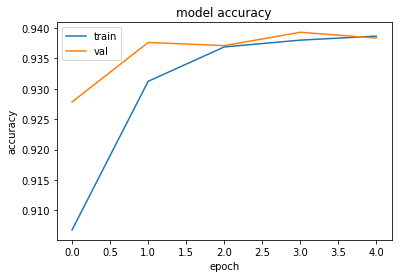

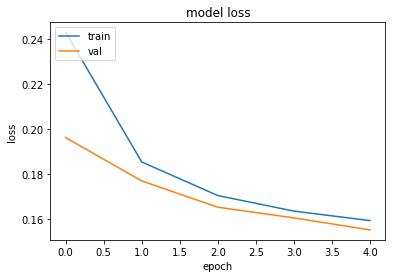

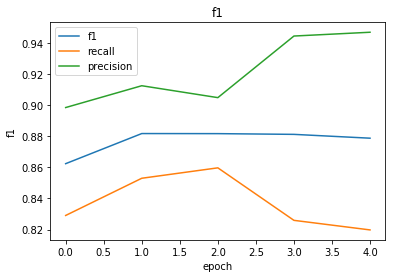

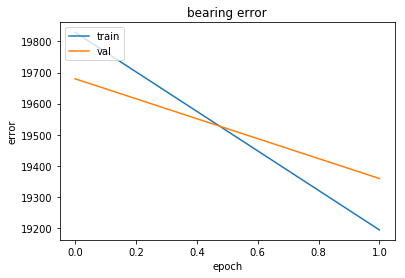

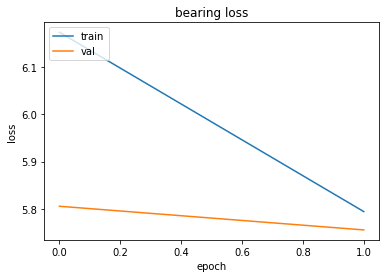

In [37]:
# summarize history for acc
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for f1, recall, precision
plt.plot(f1.val_f1s)
plt.plot(f1.val_recalls)
plt.plot(f1.val_precisions)
plt.title('f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['f1', 'recall','precision'], loc='upper left')
plt.show()

##################bearing#########################
# summarize history for acc
plt.plot(bearing_history.history['mean_squared_error'])
plt.plot(bearing_history.history['val_mean_squared_error'])
plt.title('bearing error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(bearing_history.history['loss'])
plt.plot(bearing_history.history['val_loss'])
plt.title('bearing loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()